# Assignment 7

## Comparative Analysis of Monte Carlo and n-step Temporal Difference Learning

This assignment studies and compares Monte Carlo (MC) and n-step Temporal Difference (TD) learning algorithms for value prediction.
By analyzing the effect of the step-size parameter α and the number of TD steps n, we evaluate their impact on learning accuracy using a controlled episodic environment.
The results are visualized using a heatmap of normalized average absolute error, replicating classical results from reinforcement learning literature.

### General Steps

-Defineing an episodic environment (Random Walk)

-Computeing the true value function

-Generateing multiple episodes

-Implementing MC and n-step TD prediction

-Measureing prediction error

-Averageing results over runs

-Visualizeing error as a heatmap

-Analyzeing trends in α and n

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Random Walk Environment

Defineing a simple random-walk environment where the agent moves left or right until it reaches a terminal state.

In [8]:
class RandomWalk:
    def __init__(self):
        self.states = np.arange(7)
        self.start_state = 3

    def step(self, state):
        action = np.random.choice([-1, 1])
        next_state = state + action

        reward = 0
        if next_state == 6:
            reward = 1

        return next_state, reward


### True Value Function

Storeing the true state values of the random-walk problem, which are used as a reference to measure learning error.

In [2]:
true_values = np.array([0, 1/6, 2/6, 3/6, 4/6, 5/6, 0])

### Episode Generation

Generates one full episode by letting the agent interact with the environment until a terminal state is reached.

In [3]:
def generate_episode(env):
    states = [env.start_state]
    rewards = [0]

    state = env.start_state
    while state not in [0, 6]:
        state, reward = env.step(state)
        states.append(state)
        rewards.append(reward)

    return states, rewards


### n-step TD Prediction

implementing the n-step Temporal Difference algorithm to update state values using both observed rewards and future value estimates.

In [4]:
def n_step_td(n, alpha, episodes=10):
    V = np.zeros(7)
    V[1:6] = 0.5

    env = RandomWalk()

    for _ in range(episodes):
        states, rewards = generate_episode(env)
        T = len(states)

        for t in range(T - 1):
            G = 0
            for k in range(min(n, T - t - 1)):
                G += rewards[t + k + 1]

            if t + n < T:
                G += V[states[t + n]]

            V[states[t]] += alpha * (G - V[states[t]])

    return V


### Error Computation

Computing the average absolute error between the learned values and the true values, ignoring terminal states.

In [5]:
def average_absolute_error(V):
    return np.mean(np.abs(V[1:6] - true_values[1:6]))

### Experiment Grid

Defineing the different learning rates and n-step values to be tested and prepares a matrix to store the results.

In [6]:
alphas = np.linspace(0.01, 1.0, 50)
n_values = [1, 2, 4, 8, 16, 32, 64, 128]
error_matrix = np.zeros((len(n_values), len(alphas)))
runs = 100

### Main Experiment Loop

Rrunning the learning experiment multiple times for each combination of α and n and stores the average error.

In [9]:
for i, n in enumerate(n_values):
    for j, alpha in enumerate(alphas):
        errors = []
        for _ in range(runs):
            V = n_step_td(n, alpha)
            errors.append(average_absolute_error(V))
        error_matrix[i, j] = np.mean(errors)


### Heatmap Visualization

Visualizeing the learning error as a heatmap, showing how performance changes with different values of α and n.

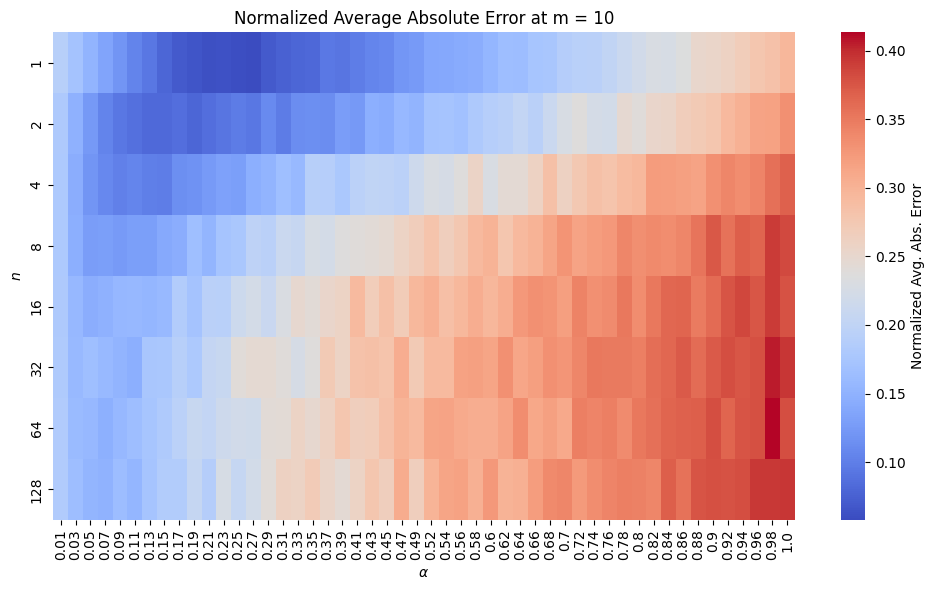

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    error_matrix,
    xticklabels=np.round(alphas, 2),
    yticklabels=n_values,
    cmap="coolwarm",
    cbar_kws={"label": "Normalized Avg. Abs. Error"}
)

plt.xlabel(r"$\alpha$")
plt.ylabel(r"$n$")
plt.title("Normalized Average Absolute Error at m = 10")
plt.tight_layout()
plt.show()

### Replicating Figure 6.2

This graph is used to compare how well Batch TD and Batch Monte Carlo learn when the learning rate (α) changes.

In short, it answers:

Which method learns more accurately, and how sensitive is it to α?

Batch Training Setup

Defineing the learning rates and how many times the experiment is repeated to get reliable averages.

In [11]:
alphas = np.linspace(0.01, 0.5, 10)
runs = 100
episodes = 10

#### Batch TD(0)

Appliening TD(0) updates repeatedly using the same batch of experience.

In [12]:
def batch_td(alpha):
    V = np.zeros(7)
    V[1:6] = 0.5
    env = RandomWalk()

    for _ in range(episodes):
        states, rewards = generate_episode(env)
        for t in range(len(states) - 1):
            V[states[t]] += alpha * (rewards[t + 1] + V[states[t + 1]] - V[states[t]])

    return average_absolute_error(V)

#### Batch Monte Carlo

Updating state values using the full return after each episode (Monte Carlo learning).

In [13]:
def batch_mc(alpha):
    V = np.zeros(7)
    V[1:6] = 0.5
    env = RandomWalk()

    for _ in range(episodes):
        states, rewards = generate_episode(env)
        G = sum(rewards)
        for s in states[:-1]:
            V[s] += alpha * (G - V[s])

    return average_absolute_error(V)


Run Experiment (Figure 6.2)

Averageing the RMS error for TD and MC over many runs for each learning rate.

In [14]:
td_errors = []
mc_errors = []

for alpha in alphas:
    td_run = []
    mc_run = []
    for _ in range(runs):
        td_run.append(batch_td(alpha))
        mc_run.append(batch_mc(alpha))
    td_errors.append(np.mean(td_run))
    mc_errors.append(np.mean(mc_run))


Plot Figure 6.2

plots the performance of Batch TD and Batch MC as learning rate changes.

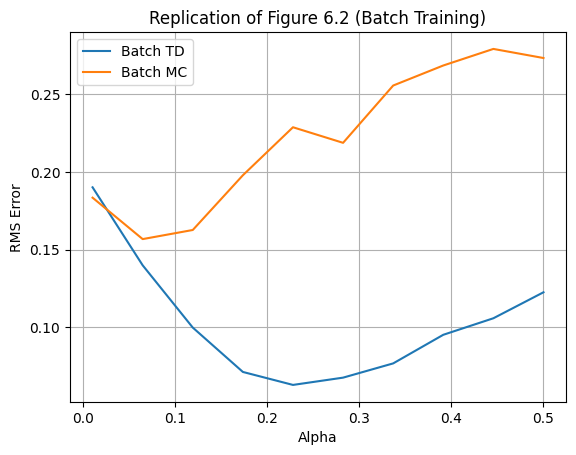

In [15]:
plt.plot(alphas, td_errors, label="Batch TD")
plt.plot(alphas, mc_errors, label="Batch MC")
plt.xlabel("Alpha")
plt.ylabel("RMS Error")
plt.title("Replication of Figure 6.2 (Batch Training)")
plt.legend()
plt.grid()
plt.show()

-Batch TD performs better than Batch MC

The blue line is consistently lower than the orange line

This means TD produces more accurate value estimates

-Batch TD is more stable

TD reaches low error quickly

Even when α increases, TD error increases slowly

### Replicating Figure 7.2

#### n-step TD Experiment

Prepareing storage for error values of different n-step TD methods.

In [16]:
n_values = [1, 2, 4, 8, 16, 32, 64]
alphas = np.linspace(0.01, 1.0, 10)
results = {n: [] for n in n_values}

#### Run n-step TD Curves

In [19]:
results = {n: [] for n in n_values}

for n in n_values:
    for alpha in alphas:
        errors = []
        for _ in range(runs):
            V = n_step_td(n, alpha)
            errors.append(average_absolute_error(V))
        results[n].append(np.mean(errors))


Computeing the average RMS error for each combination of n and α.

#### Plot Figure 7.2

This graph is used to compare different n-step Temporal Difference (TD) methods and see how the choice of n and the learning rate (α) affects performance.

Visualizeing how different n-step TD methods perform as α changes.

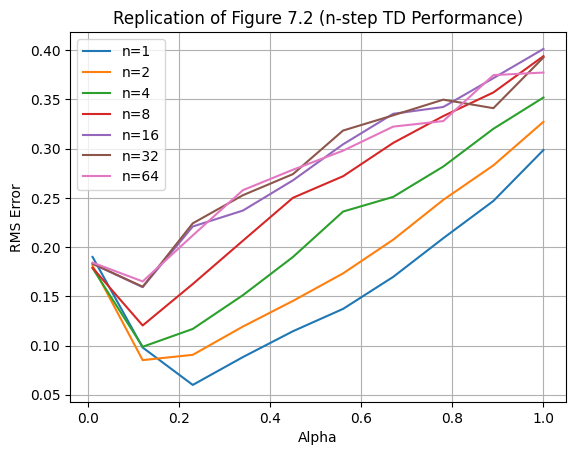

In [20]:
for n in n_values:
    plt.plot(alphas, results[n], label=f"n={n}")

plt.xlabel("Alpha")
plt.ylabel("RMS Error")
plt.title("Replication of Figure 7.2 (n-step TD Performance)")
plt.legend()
plt.grid()
plt.show()


-Learning rate matters for all n

For very small α, all methods perform similarly

For large α, error increases for all methods

-Small n (e.g., n = 1) is more stable

n = 1 (TD(0)) has lower error at smaller α

It is less sensitive to changes in α

-Large n behaves like Monte Carlo

Large n (e.g., 32, 64) has higher error

Performance degrades faster as α increases